<a href="https://colab.research.google.com/github/MohamedAlmaki/Pytorch-Challenge-Scholarship-lab/blob/master/Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an AI application

## **NOTE:** 

This is slightly edited notebook to help you with downloaing and loading image datasets. I have left the exercise parts untouched and you have to fill them, ofcourse. If you have any issue with this notebook, feel free to contact me `avinash` on Slack :D

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

# Tips, Model Performance, Submission Troubleshooting, etc 

The amazing people at Slack have compiled an amazing list of tips for this project. Check it here - [link](https://docs.google.com/document/d/1-MCDPOejsn2hq9EoBzMpzGv9jEdtMWoIwjkAa1cVbSM/edit#heading=h.yspy8tt3f0xe)

In [1]:
#Installing pytorch (You can skip this if you are not running the notebook in google colab)

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5b696000 @  0x7faa0660d2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
fastai 1.0.41 has requirement torch>=1.0.0, but you'll have torch 0.4.0 which is incompatible.
0.4.0
True


In [1]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
#!pip uninstall -y Pillow
# install the new one
#!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

5.3.0


In [0]:
#Imports  

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import torch 
from torch import nn
from torch import optim 
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models, transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import os 
import numpy as np
import time
import copy 


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
# we will download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

rm: cannot remove 'flower_data': No such file or directory


In [5]:
'''
Data augmentation and normalization for training. 
The dataset is splitted in to : 
- 80% training 
- 10% testing
- 10% validation 
'''

#Data transforms for augmenting the dataset. 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45), 
        transforms.ColorJitter(brightness=0.2, hue=.1, saturation=.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#Loading the dataset folders ('train', 'valid')
data_dir = 'flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

#Creating random indices for sampling dataset. 
num_train = len(image_datasets['train'])
indices = list(range(num_train))
split = 818
np.random.seed(42)
np.random.shuffle(indices)

#Sampling the dataset using "SubsetRandomSampler" from pytorch utils.
train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

#train, test and validation data loaders
train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, sampler=test_sampler)
valid_loader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64, shuffle=True)

print(len(train_loader))
print(len(test_loader))
print(len(valid_loader))
# train_data = 5734
# test_data = 818
# validation_data = 818


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

90
13
13


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

torch.Size([32, 3, 224, 224])
torch.Size([32])
sword lily


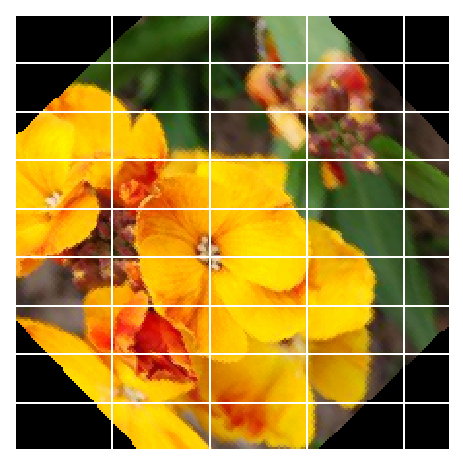

In [7]:
import matplotlib.pyplot as plt
import json

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

sampler_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True)
examples, labels = next(iter(sampler_loader))
print(examples.shape)
print(labels.shape)
imshow(examples[0], normalize=True)
print(cat_to_name['{}'.format(labels[0])])

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
'''
Transfer learning is used here. 
A pretrained model (resnet152) is used . 
The classifier part of the pretrained model (The last fully connected layers) is replaced with one layer with dropout. 
The conv layers are freezed and the classifer is unfreezed 
'''

#Loading the pretrained model from torchvision models 
resnet152 = models.resnet152(pretrained=True)

#Freezing conv layers parameters 
for parm in resnet152.parameters(): 
  parm.requires_grad = False

#The new classifier archeticure 
classifier = nn.Sequential(nn.Dropout(p=0.25),
                           nn.Linear(2048, 102),
                           nn.LogSoftmax(dim=1))

#Changing the classifier
resnet152.fc = classifier

#The Loss criterion 
criterion = nn.NLLLoss()

#Optimizer 
optimizer = optim.Adam(resnet152.fc.parameters(), lr=0.002)

#learning rate schedular 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model = resnet152.to(device)

In [0]:
#Helping dicts
dataloaders = {
    'train': train_loader,
    'val': valid_loader
}
dataset_sizes = {
    'train': 5734, 
     'val': 818
}

In [0]:
#This function train a given model and return the best model (The highest validation accuracy). 
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    outputs = torch.exp(outputs)
                    _, preds = torch.max(outputs, 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print('accuracy improved : saving the model....')
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
#Traing the model
best_model = train_model(model, criterion, optimizer, scheduler, 10)

Epoch 0/9
----------
train Loss: 3.1065 Acc: 0.3471
val Loss: 1.3577 Acc: 0.6993
accuracy improved : saving the model....

Epoch 1/9
----------
train Loss: 1.5266 Acc: 0.6376
val Loss: 0.8045 Acc: 0.8032
accuracy improved : saving the model....

Epoch 2/9
----------
train Loss: 1.2445 Acc: 0.6939
val Loss: 0.6650 Acc: 0.8423
accuracy improved : saving the model....

Epoch 3/9
----------
train Loss: 1.0804 Acc: 0.7234
val Loss: 0.6743 Acc: 0.8105

Epoch 4/9
----------
train Loss: 1.0236 Acc: 0.7318
val Loss: 0.5412 Acc: 0.8521
accuracy improved : saving the model....

Epoch 5/9
----------
train Loss: 0.8807 Acc: 0.7736
val Loss: 0.4343 Acc: 0.8936
accuracy improved : saving the model....

Epoch 6/9
----------
train Loss: 0.8085 Acc: 0.7871
val Loss: 0.4291 Acc: 0.8888

Epoch 7/9
----------
train Loss: 0.7938 Acc: 0.7851
val Loss: 0.4213 Acc: 0.8900

Epoch 8/9
----------
train Loss: 0.7770 Acc: 0.7956
val Loss: 0.3786 Acc: 0.9059
accuracy improved : saving the model....

Epoch 9/9
------

In [0]:
#Reset lr and train again
for parm in optimizer.param_groups: 
  parm['lr'] = 0.002
good_model = train_model(best_model, criterion, optimizer, scheduler, 10)

Epoch 0/9
----------
train Loss: 0.7320 Acc: 0.8050
val Loss: 0.4143 Acc: 0.8924
accuracy improved : saving the model....

Epoch 1/9
----------
train Loss: 0.7117 Acc: 0.8075
val Loss: 0.3757 Acc: 0.9010
accuracy improved : saving the model....

Epoch 2/9
----------
train Loss: 0.6962 Acc: 0.8176
val Loss: 0.3410 Acc: 0.9169
accuracy improved : saving the model....

Epoch 3/9
----------
train Loss: 0.6917 Acc: 0.8200
val Loss: 0.3572 Acc: 0.9120

Epoch 4/9
----------
train Loss: 0.7114 Acc: 0.8136
val Loss: 0.3398 Acc: 0.9034

Epoch 5/9
----------
train Loss: 0.6799 Acc: 0.8214
val Loss: 0.3527 Acc: 0.9083

Epoch 6/9
----------
train Loss: 0.6582 Acc: 0.8253
val Loss: 0.3346 Acc: 0.9059

Epoch 7/9
----------
train Loss: 0.6521 Acc: 0.8273
val Loss: 0.3339 Acc: 0.9156

Epoch 8/9
----------
train Loss: 0.6722 Acc: 0.8225
val Loss: 0.3291 Acc: 0.9132

Epoch 9/9
----------
train Loss: 0.6551 Acc: 0.8258
val Loss: 0.3394 Acc: 0.9156

Training complete in 43m 53s
Best val Acc: 0.916870


In [0]:
for parm in optimizer.param_groups: 
  parm['lr'] = 0.0002
nice_model = train_model(good_model, criterion, optimizer, scheduler, 20)

Epoch 0/19
----------
train Loss: 0.6801 Acc: 0.8249
val Loss: 0.3288 Acc: 0.9120
accuracy improved : saving the model....

Epoch 1/19
----------
train Loss: 0.6674 Acc: 0.8279
val Loss: 0.3320 Acc: 0.9181
accuracy improved : saving the model....

Epoch 2/19
----------
train Loss: 0.6712 Acc: 0.8232
val Loss: 0.3394 Acc: 0.9108

Epoch 3/19
----------
train Loss: 0.6425 Acc: 0.8319
val Loss: 0.3424 Acc: 0.9132

Epoch 4/19
----------
train Loss: 0.6612 Acc: 0.8249
val Loss: 0.3401 Acc: 0.9095

Epoch 5/19
----------
train Loss: 0.6555 Acc: 0.8242
val Loss: 0.3312 Acc: 0.9132

Epoch 6/19
----------
train Loss: 0.6239 Acc: 0.8371
val Loss: 0.3329 Acc: 0.9169

Epoch 7/19
----------
train Loss: 0.6589 Acc: 0.8336
val Loss: 0.3365 Acc: 0.9156

Epoch 8/19
----------
train Loss: 0.6266 Acc: 0.8376
val Loss: 0.3204 Acc: 0.9144

Epoch 9/19
----------
train Loss: 0.6500 Acc: 0.8321
val Loss: 0.3228 Acc: 0.9132

Epoch 10/19
----------
train Loss: 0.6430 Acc: 0.8305
val Loss: 0.3298 Acc: 0.9120

Epoc

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [11]:
'''
Saving the trained model in google drive. 
Note: You must mount google drive first in order to save or load 
'''
#Mounting google drive to google colab 
#after authorization you will find you google drive directories in google colab files (right arrow in the left)
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Saving the model in google drive 
def save(states, name): 
  model_save_name = name
  path = F"/content/gdrive/My Drive/{model_save_name}" 
  torch.save(states, path)
save(nice_model.state_dict(), "new.pth")

In [0]:
#A better version of saving (It will not work for colab because its ram is limited. But it will works for small models)
#In this version we not only save model parameters but also optimizer and scheduler parameter so this function is better if you want to continue your trainig 
def save_2(model, name, arch, epochs): 
  model.class_to_idx = image_datasets['train']
  states = {
    'epoch': epochs + 1, 
    'arch': arch , 
    'state_dict': best_model.state_dict(), 
    'optimizer': optimizer.state_dict(), 
    'scheduler': scheduler.state_dict(), 
    'class_to_idx': best_model.class_to_idx
  }
  save(states, name)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# Load function for simplified save function 
def load(name):
  path = F"/content/gdrive/My Drive/{name}"
  check = torch.load(path)
  
  model = models.resnet152(pretrained=True)
  for param in model.parameters(): 
    param.requires_gard = False
    
  classifier = nn.Sequential(nn.Dropout(p=0.5),
                           nn.Linear(2048,102), 
                           nn.LogSoftmax(dim=1))
  model.fc = classifier
  
  model.load_state_dict(check)
    
  model.to(device)
  return model 

In [0]:
#load function for save_2 function 
def load_2(name):
  path = F"/content/gdrive/My Drive/{name}"
  check = torch.load(path)
  
  arch = check['arch']
  code = "models." + arch + "(pretrained=True)"
  model = exec(code)
  
  classifier = nn.Sequential(nn.Dropout(p=0.5),
                           nn.Linear(2048,102), 
                           nn.LogSoftmax(dim=1))
  model.fc = classifier 
    
  model.load_state_dict(check['state_dict'])
  model.class_to_idx = check['class_to_idx']
    
  optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
  optimizer.load_state_dict(check['optimizer'])

  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
  scheduler.load_state_dict(check['scheduler'])
    
  epoch = check['epoch']
  model.cuda(), epoch
    

In [0]:
model = load("new.pth")

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
from PIL import Image
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    image = Image.open(path).convert('RGB')
  
    transform = transforms.Compose([
      transforms.Resize(256), 
      transforms.CenterCrop(244), 
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), 
                          (0.229, 0.224, 0.225))
    ])
  
    image = transform(image)[:3, :, :]
    return image
    
    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
 def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    image = process_image(image_path)
    preds = model(image)
    preds = torch.exp(preds)
   
    return preds.topk(k)
    
    
    # TODO: Implement the code to predict the class from an image file

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [0]:
# TODO: Display an image along with the top 5 classes
def view_image(image, classes, ps): 
  ps = ps.data.numpy().squeeze()
  
  classes = classes.numpy().squeeze()
  
  fig, (ax1,ax2) = plt.subplots(figsize=(6,9), ncols=2)
  image = image.numpy().transpose((1, 2, 0))

   
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  image = np.clip(image, 0, 1)

  ax1.imshow(image)
  ax1.spines['top'].set_visible(False)
  ax1.spines['right'].set_visible(False)
  ax1.spines['left'].set_visible(False)
  ax1.spines['bottom'].set_visible(False)
  ax1.tick_params(axis='both', length=0)
  ax1.set_xticklabels('')
  ax1.set_yticklabels('')
  
  
  ax2.barh(np.arange(5), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(5))
  ax2.set_yticklabels(classes)
  ax2.set_title('Class Probability..')
  ax2.set_xlim(0, 1.1)
  
  plt.tight_layout()

In [0]:
def test_model(model, criterion):
    
           
            model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(False):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                        
                    outputs = torch.exp(outputs)
                    _, preds = torch.max(outputs, 1)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            loss = running_loss / dataset_sizes['val']
            acc = running_corrects.double() / dataset_sizes['val']

            return loss,acc

torch.LongTensor


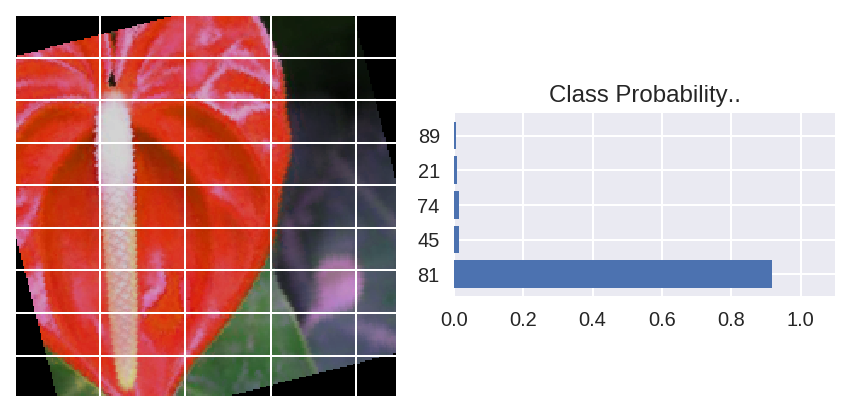

In [89]:
images, labels = iter(test_loader).next()

image = images[0]
label = labels[0]
model.cpu()
inp = image.unsqueeze(0)

preds = model(inp)
preds= torch.exp(preds)
ps, classes = torch.topk(preds, 5)
print(classes.type())
classes = classes.detach()

view_image(image, classes, ps)

In [90]:
print(label)

tensor(81)
